In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

import torchvision.datasets as dset

In [2]:
def norm(data, mu=1):
    return 2 * (data / 255.) - mu

def imshow(img):
    img = img / 2 + 0.5     # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [3]:
root = './data'
class_ind = 1

BATCH = 4

testset = dset.CIFAR10(root, train=False, download=True)
test_data = np.array(testset.data)
test_labels = np.array(testset.targets)



100%|██████████| 170498071/170498071 [00:14<00:00, 11969912.44it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


In [4]:
classes = testset.classes

x_test = norm(np.asarray(test_data, dtype='float32'))
x_test_trans = x_test.transpose(0, 3, 1, 2)
y_test = (np.array(test_labels) == class_ind)

x_test_trans = x_test_trans.reshape(-1,BATCH,3,32,32)
y_test_trans = test_labels.reshape(-1,BATCH)

In [5]:
# 학습용 이미지 뽑기
img_dataiter = iter(x_test_trans)
label_dataiter = iter(y_test_trans)

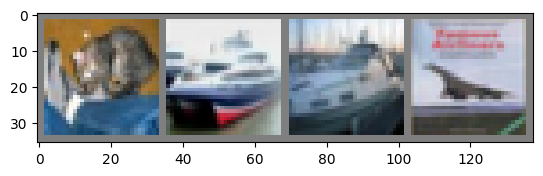


  cat  ship  ship airplane


In [6]:
# 학습용 이미지 뽑기

images = next(img_dataiter)
labels = next(label_dataiter)

# 이미지 보여주기
images_tensor = torch.from_numpy(images)
imshow(torchvision.utils.make_grid(images_tensor))
print()
# 이미지별 라벨 (클래스) 보여주기
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH)))

In [7]:
normal_x_test = x_test[y_test]
normal_x_test_trans = normal_x_test.transpose(0, 3, 1, 2)
normal_x_test_trans = normal_x_test_trans.reshape(-1,BATCH,3,32,32)
normal_img_dataiter = iter(normal_x_test_trans)

new_y_test = [not y for y in y_test]
abnormal_x_test = x_test[new_y_test]
abnormal_x_test_trans = abnormal_x_test.transpose(0, 3, 1, 2)
abnormal_x_test_trans = abnormal_x_test_trans.reshape(-1,BATCH,3,32,32)
abnormal_img_dataiter = iter(abnormal_x_test_trans)

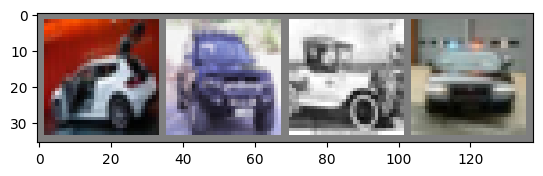

In [8]:
# normal 이미지 보여주기
normal_images = next(normal_img_dataiter)
normal_images_tensor = torch.from_numpy(normal_images)
imshow(torchvision.utils.make_grid(normal_images_tensor))

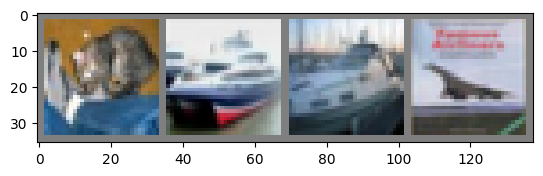

In [9]:
# abnormal 이미지 보여주기
abnormal_images = next(abnormal_img_dataiter)
abnormal_images_tensor = torch.from_numpy(abnormal_images)
imshow(torchvision.utils.make_grid(abnormal_images_tensor))

#### 데이터 몇개 가져와서 transforming하고 모델에 넣고 평균값 기준 normal과 abnormal 구분하기

In [35]:
import utils.transformations as ts
def transform_data(data, trans):
    trans_inds = np.tile(np.arange(trans.n_transforms), len(data))
    trans_data = trans.transform_batch(np.repeat(np.array(data), trans.n_transforms, axis=0), trans_inds)
    return trans_data, trans_inds

In [36]:
type_trans = 'simple'
transformer = ts.get_transformer(type_trans)

In [37]:
test_data = np.array(testset.data)
test_labels = np.array(testset.targets)
x_test = norm(np.asarray(test_data, dtype='float32'))

y_test_normal = (np.array(y_test) == class_ind)
y_test_abnormal = (np.array(y_test) != class_ind)

In [38]:
x_test_normal = x_test[y_test_normal]
x_test_abnormal = x_test[y_test_abnormal]

#### normal 이미지 또는 abnormal 이미지 하나 고르기 

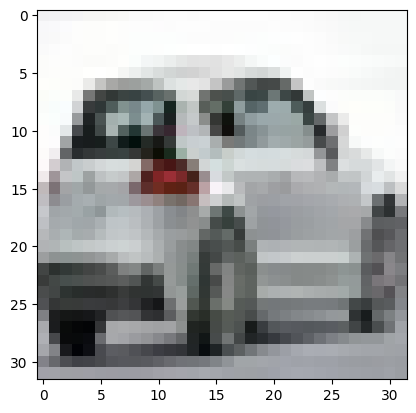

In [39]:
test_image = x_test_normal[10]


normal_images_tensor = torch.from_numpy(test_image.transpose(2, 0, 1))
imshow(torchvision.utils.make_grid(normal_images_tensor))

### 모델 로드

In [40]:
import training.opt_tc as tc
from networks.wideresnet import WideResNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


depth = 10
num_trans = transformer.n_transforms
widen_factor = 4

load_model = './checkpoints/cifa10/{}_best_model.pth'.format(classes[class_ind])
print(load_model)

netWRN = WideResNet(depth, num_trans, widen_factor).to(device)
netWRN.load_state_dict(torch.load(load_model)['net_dict'])
normal_means = torch.load(load_model)['normal']
print('normal_means:', normal_means.shape)

./result/automobile_best_model.pth
normal_means: torch.Size([1, 8, 256])


In [47]:
# 테스트 함수 
def one_img_test(test_image):
    h,w,c = test_image.shape
    test_image = test_image.reshape(-1, h,w,c)
    test_image, _ = transform_data(test_image, transformer)
    test_image_trans = test_image.transpose(0, 3, 1, 2)
    print("Test")
    netWRN.eval()
    n_rots = num_trans
    n_rots_test = n_rots
    ndf = 256
    eps = 0

    val_probs_rots = np.zeros((1, n_rots_test))
    xs = torch.from_numpy(test_image_trans).float().to(device) 
    zs, fs = netWRN(xs)
    zs = torch.reshape(zs, (1, n_rots_test, ndf))    # ([576, 256])

    diffs = ((zs.unsqueeze(2) - normal_means) ** 2).sum(-1)
    diffs_eps = eps * torch.ones_like(diffs)
    diffs = torch.max(diffs, diffs_eps)
    logp_sz = torch.nn.functional.log_softmax(-diffs, dim=2)

    val_probs_rots = -torch.diagonal(logp_sz, 0, 1, 2).cpu().data.numpy()
    val_probs_rots = val_probs_rots.sum(1)
    return val_probs_rots


#### 정상 데이터

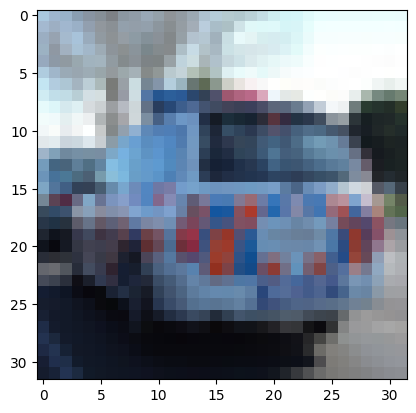

........data transforming.........


trainsforming: 100%|██████████| 8/8 [00:00<00:00, 8019.70it/s]

Test


array([8.524939], dtype=float32)

In [49]:
test_image = x_test_normal[101]


normal_images_tensor = torch.from_numpy(test_image.transpose(2, 0, 1))
imshow(torchvision.utils.make_grid(normal_images_tensor))

score = one_img_test(test_image)

score

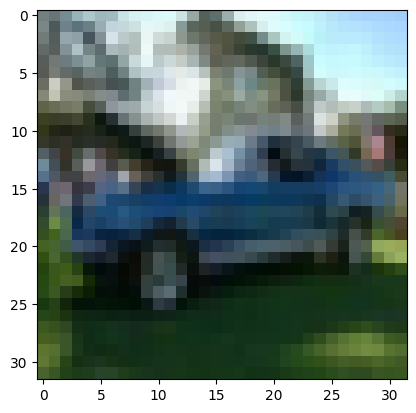

........data transforming.........


trainsforming: 100%|██████████| 8/8 [00:00<00:00, 8017.79it/s]

Test


array([8.831994], dtype=float32)

In [50]:
test_image = x_test_normal[501]


normal_images_tensor = torch.from_numpy(test_image.transpose(2, 0, 1))
imshow(torchvision.utils.make_grid(normal_images_tensor))

score = one_img_test(test_image)

score

### 비정상 데이터

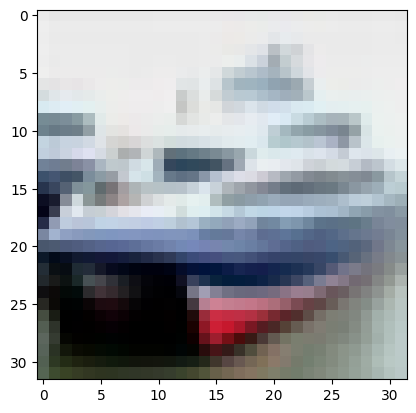

........data transforming.........


trainsforming: 100%|██████████| 8/8 [00:00<?, ?it/s]

Test


array([6.973263], dtype=float32)

In [51]:
test_image = x_test_abnormal[1]


normal_images_tensor = torch.from_numpy(test_image.transpose(2, 0, 1))
imshow(torchvision.utils.make_grid(normal_images_tensor))

score = one_img_test(test_image)

score

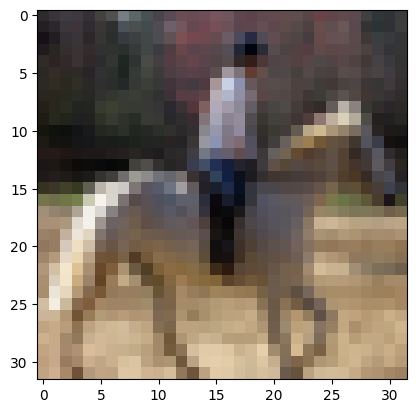

........data transforming.........


trainsforming: 100%|██████████| 8/8 [00:00<?, ?it/s]

Test


array([16.749256], dtype=float32)

In [52]:
test_image = x_test_abnormal[400]


normal_images_tensor = torch.from_numpy(test_image.transpose(2, 0, 1))
imshow(torchvision.utils.make_grid(normal_images_tensor))

score = one_img_test(test_image)

score